# Proton data in dilepton events

### Install packages

In [1]:
#!python3 -m pip install uproot4 awkward1 mplhep

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep

The data is first processed from a ROOT n-tuple. Below is an n-tuple from an MC sample.  
Look for the _ProtCand_ data defining the proton objects.

In [3]:
import uproot4
import awkward1 as ak

root = uproot4.open( "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/MC-2017-v1/output_exclusive_new.root" )
tree = root["ggll_miniaod/ntp1"]

keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
keys.append( "nPfCand" )
keys.extend( tree.keys( filter_name="PfCand*" ) ) 
keys.append( "nRecoProtCand" )
keys.extend( tree.keys( filter_name="ProtCand*" ) )

arrays = tree.arrays( keys, library="ak", how="zip", entry_stop=10000 )
ak.to_list( arrays[:10] )

[{'Run': 1,
  'LumiSection': 1,
  'BX': 4294967295,
  'EventNum': 11,
  'CrossingAngle': -999.0,
  'nHLT': 3,
  'HLT_Name': ['HLT_DoubleMu43NoFiltersNoVtx_*',
   'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8_*',
   'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8_*'],
  'nMuonCand': 2,
  'nPrimVertexCand': 18,
  'Weight': 1.1115721770704978,
  'PUWeightTrue': 0.0,
  'nPfCand': 8,
  'nRecoProtCand': 0,
  'HLT': [{'Accept': 1, 'Prescl': 1},
   {'Accept': 1, 'Prescl': 1},
   {'Accept': 1, 'Prescl': 1}],
  'MuonCand': [{'pt': 64.26155090332031,
    'eta': -0.5968616604804993,
    'phi': -1.6632956266403198,
    'e': 76.05188502900157,
    'charge': 1,
    'vtxz': 5.145226001739502,
    'istight': 1},
   {'pt': 61.580448150634766,
    'eta': 1.0376110076904297,
    'phi': 1.481685996055603,
    'e': 97.81340011244389,
    'charge': -1,
    'vtxz': 5.143592357635498,
    'istight': 1}],
  'PrimVertexCand': [{'z': 5.1456708908081055,
    'chi2': 6.601336479187012,
    'ndof': 5,
    'tracks': 0},
  

The n-tuples are processed and the follwing event selection is applied:  
...

The data is then _flattened_ over the proton objects, as will be seen below.

In [4]:
fileName_signal = "data/output-MC2017-Elastic-PreSel.h5"
fileName_data = "data/output-UL2017B-PreSel.h5"

proton_selection = "SingleRP"
#proton_selection = "MultiRP"

# Signal

## Access the data

In [5]:
df_signal = None
event_counts_signal = None
selections_str_signal = None

with h5py.File( fileName_signal, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal = pd.DataFrame( dset, columns=columns_str )


['columns', 'event_counts', 'protons', 'selections']
(212317, 28)
[[1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 9.13764843e-04
  2.35298625e-02 4.41197067e-03]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 ...
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.50995244e-04
  2.04409396e-02 4.87857127e-03]]
(28,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlu

In [6]:
df_counts_signal = pd.Series( event_counts_signal, index=selections_str_signal );
df_counts_signal

Muon       166756
Vertex     149608
Protons     90874
dtype: int64

In [7]:
df_signal[:20]

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,1.0,1.0,4.294967e+09,5.0,-999.0,0.023317,0.0,-999.0,23.0,-1.0,...,62.647861,1.164667,2.705973,-0.882422,-0.880501,132.454602,34.0,0.000914,0.023530,0.004412
1,1.0,1.0,4.294967e+09,3.0,-999.0,0.109950,0.0,-999.0,103.0,-1.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
2,1.0,1.0,4.294967e+09,3.0,-999.0,0.113496,0.0,-999.0,123.0,-1.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
3,1.0,1.0,4.294967e+09,3.0,-999.0,0.081234,1.0,1.0,103.0,123.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
4,1.0,1.0,4.294967e+09,12.0,-999.0,0.043718,0.0,-999.0,3.0,-1.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
5,1.0,1.0,4.294967e+09,12.0,-999.0,0.041904,0.0,-999.0,23.0,-1.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
6,1.0,1.0,4.294967e+09,12.0,-999.0,0.054572,1.0,0.0,3.0,23.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
7,1.0,1.0,4.294967e+09,15.0,-999.0,0.069101,0.0,-999.0,103.0,-1.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651
8,1.0,1.0,4.294967e+09,15.0,-999.0,0.069230,0.0,-999.0,123.0,-1.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651
9,1.0,1.0,4.294967e+09,15.0,-999.0,0.068238,1.0,1.0,103.0,123.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651


In [8]:
msk_invmass = ( df_signal["InvMass"] >= 110. )
df_signal = df_signal[msk_invmass]
df_signal[:20]

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,1.0,1.0,4.294967e+09,5.0,-999.0,0.023317,0.0,-999.0,23.0,-1.0,...,62.647861,1.164667,2.705973,-0.882422,-0.880501,132.454602,34.0,0.000914,0.023530,0.004412
1,1.0,1.0,4.294967e+09,3.0,-999.0,0.109950,0.0,-999.0,103.0,-1.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
2,1.0,1.0,4.294967e+09,3.0,-999.0,0.113496,0.0,-999.0,123.0,-1.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
3,1.0,1.0,4.294967e+09,3.0,-999.0,0.081234,1.0,1.0,103.0,123.0,...,114.552933,-1.007581,2.132689,3.432269,3.430571,251.395353,16.0,0.000880,0.004588,0.081510
4,1.0,1.0,4.294967e+09,12.0,-999.0,0.043718,0.0,-999.0,3.0,-1.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
5,1.0,1.0,4.294967e+09,12.0,-999.0,0.041904,0.0,-999.0,23.0,-1.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
6,1.0,1.0,4.294967e+09,12.0,-999.0,0.054572,1.0,0.0,3.0,23.0,...,52.814793,1.151121,2.015797,2.280747,2.282250,126.690612,4.0,0.001160,0.055618,0.001708
7,1.0,1.0,4.294967e+09,15.0,-999.0,0.069101,0.0,-999.0,103.0,-1.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651
8,1.0,1.0,4.294967e+09,15.0,-999.0,0.069230,0.0,-999.0,123.0,-1.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651
9,1.0,1.0,4.294967e+09,15.0,-999.0,0.068238,1.0,1.0,103.0,123.0,...,88.274399,-1.960430,0.968317,0.532098,0.540000,195.115391,10.0,0.000011,0.003281,0.068651


Text(0, 0.5, 'Y (mm)')

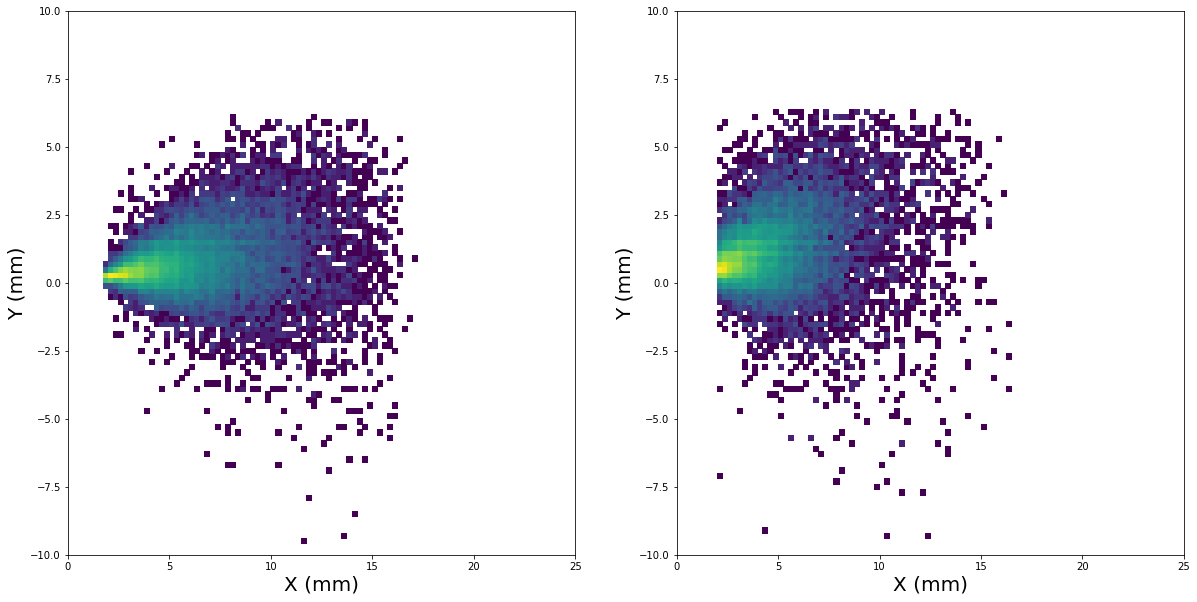

In [9]:
from matplotlib.colors import LogNorm

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_signal[ "TrackX1" ][ msk_protons_1 ], df_signal[ "TrackY1" ][ msk_protons_1 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_signal[ "TrackX1" ][ msk_protons_2 ], df_signal[ "TrackY1" ][ msk_protons_2 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: SingleRP
Number of protons: 34543, 24034


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

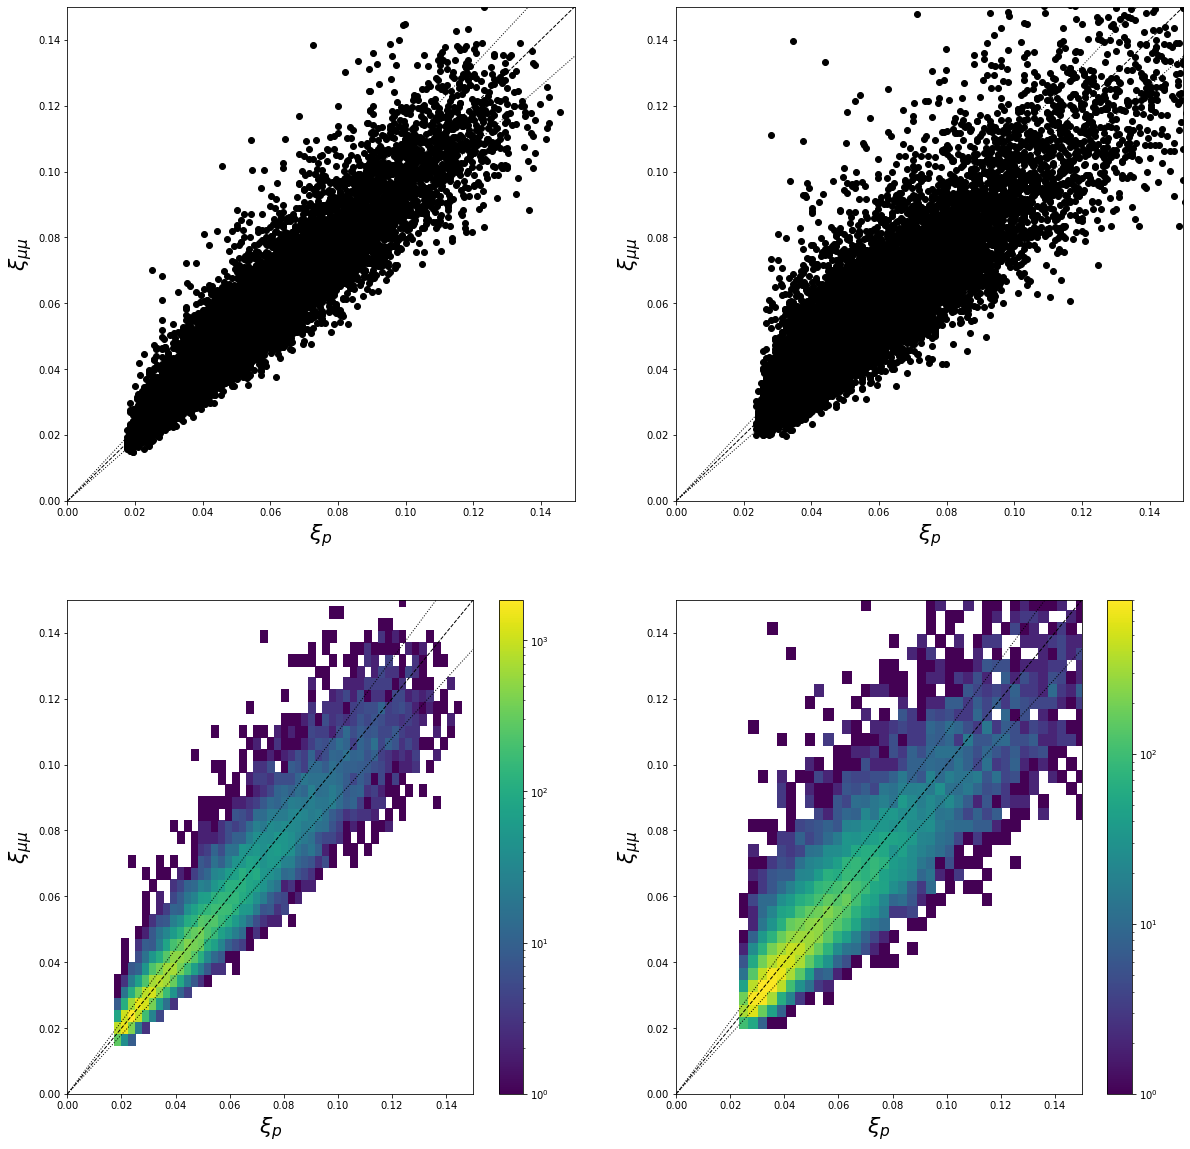

In [10]:
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_signal[ "Xi" ][ msk_protons_1 ] ), len( df_signal[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
#axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22, ha='right', x=1.0 )
#axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22, ha='right', y=1.0 )
axes[0,1].plot( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

# Data

In [11]:
df_data = None
event_counts_data = None
selections_str_data = None

with h5py.File( fileName_data, 'r') as f:    
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )

    dset_counts = f['event_counts']
    event_counts_data = list( dset_counts )
    print ( event_counts_data )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_data = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_data )  

    df_data = pd.DataFrame( dset, columns=columns_str )

['columns', 'event_counts', 'protons', 'selections']
(107075, 28)
[[2.97227000e+05 5.30000000e+01 2.29700000e+03 ... 9.83012105e-01
  5.61954090e-02 4.09129155e-03]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 ...
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]]
(28,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlu

In [12]:
df_counts_data = pd.Series( event_counts_data, index=selections_str_data);
df_counts_data

Muon       47151
Vertex     44057
Protons    32009
dtype: int64

In [13]:
df_data[:20]

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,297227.0,53.0,2297.0,36577201.0,120.0,0.029290,0.0,-999.0,123.0,-1.0,...,63.807861,1.228711,-2.968801,7.642523,7.640311,12.129827,48.0,0.983012,0.056195,0.004091
1,297227.0,55.0,867.0,38079658.0,120.0,0.055317,0.0,-999.0,103.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
2,297227.0,55.0,867.0,38079658.0,120.0,0.053598,0.0,-999.0,123.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
3,297227.0,55.0,867.0,38079658.0,120.0,0.067306,1.0,1.0,103.0,123.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
4,297227.0,56.0,1102.0,38791639.0,120.0,0.098331,0.0,-999.0,103.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
5,297227.0,56.0,1102.0,38791639.0,120.0,0.097884,0.0,-999.0,123.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
6,297227.0,56.0,1102.0,38791639.0,120.0,0.102869,1.0,1.0,103.0,123.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
7,297227.0,56.0,378.0,38604580.0,120.0,0.037838,0.0,-999.0,3.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210
8,297227.0,56.0,378.0,38604580.0,120.0,0.038086,0.0,-999.0,23.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210
9,297227.0,56.0,378.0,38604580.0,120.0,0.043100,0.0,-999.0,103.0,-1.0,...,70.969543,-1.393078,-2.552279,1.891896,1.899735,90.916580,28.0,0.588286,0.003354,0.038210


In [14]:
msk_invmass = ( df_data["InvMass"] >= 110. )
df_data = df_data[msk_invmass]
df_data[:20]

,Run,LumiSection,BX,EventNum,CrossingAngle,Xi,MultiRP,Arm,RPId1,RPId2,...,Muon1Pt,Muon1Eta,Muon1Phi,Muon1VtxZ,PrimVertexZ,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
1,297227.0,55.0,867.0,38079658.0,120.0,0.055317,0.0,-999.0,103.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
2,297227.0,55.0,867.0,38079658.0,120.0,0.053598,0.0,-999.0,123.0,-1.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
3,297227.0,55.0,867.0,38079658.0,120.0,0.067306,1.0,1.0,103.0,123.0,...,62.493637,-1.693658,-0.273957,-0.406477,-0.412115,123.616515,27.0,0.132612,0.001953,0.048346
4,297227.0,56.0,1102.0,38791639.0,120.0,0.098331,0.0,-999.0,103.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
5,297227.0,56.0,1102.0,38791639.0,120.0,0.097884,0.0,-999.0,123.0,-1.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
6,297227.0,56.0,1102.0,38791639.0,120.0,0.102869,1.0,1.0,103.0,123.0,...,65.022888,-1.087328,-0.051032,-1.935442,-1.928177,152.786010,29.0,0.058782,0.002211,0.062855
18,297227.0,59.0,1091.0,41195314.0,120.0,0.054267,0.0,-999.0,3.0,-1.0,...,53.397972,0.351230,1.455985,1.699705,1.701242,115.758900,30.0,0.476683,0.007220,0.015363
19,297227.0,59.0,1091.0,41195314.0,120.0,0.030869,0.0,-999.0,23.0,-1.0,...,53.397972,0.351230,1.455985,1.699705,1.701242,115.758900,30.0,0.476683,0.007220,0.015363
23,297227.0,60.0,2102.0,41478175.0,120.0,0.032062,0.0,-999.0,123.0,-1.0,...,93.884605,-0.780826,-1.171839,-2.750041,-2.746576,323.668558,40.0,0.157789,0.035037,0.018197
37,297227.0,71.0,517.0,50687027.0,120.0,0.047071,0.0,-999.0,3.0,-1.0,...,113.611771,-1.225648,2.078576,3.568076,3.565264,270.992400,27.0,0.016921,0.010428,0.041786


Text(0, 0.5, 'Y (mm)')

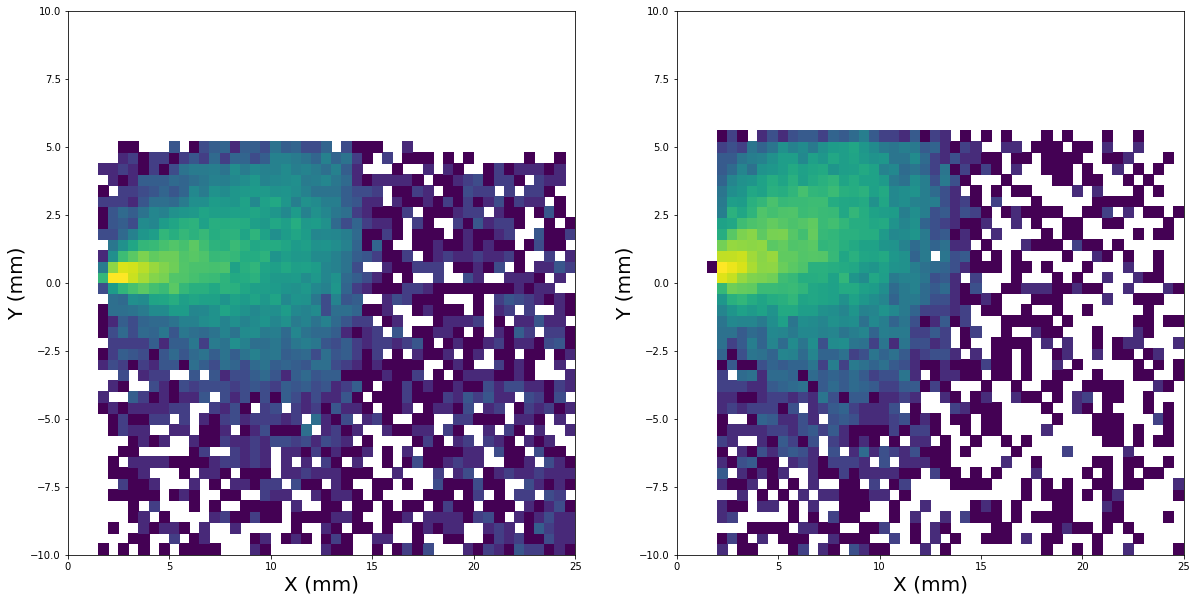

In [15]:
msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_data[ "TrackX1" ][ msk_protons_1 ], df_data[ "TrackY1" ][ msk_protons_1 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_data[ "TrackX1" ][ msk_protons_2 ], df_data[ "TrackY1" ][ msk_protons_2 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: SingleRP
Number of protons: 55, 47


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

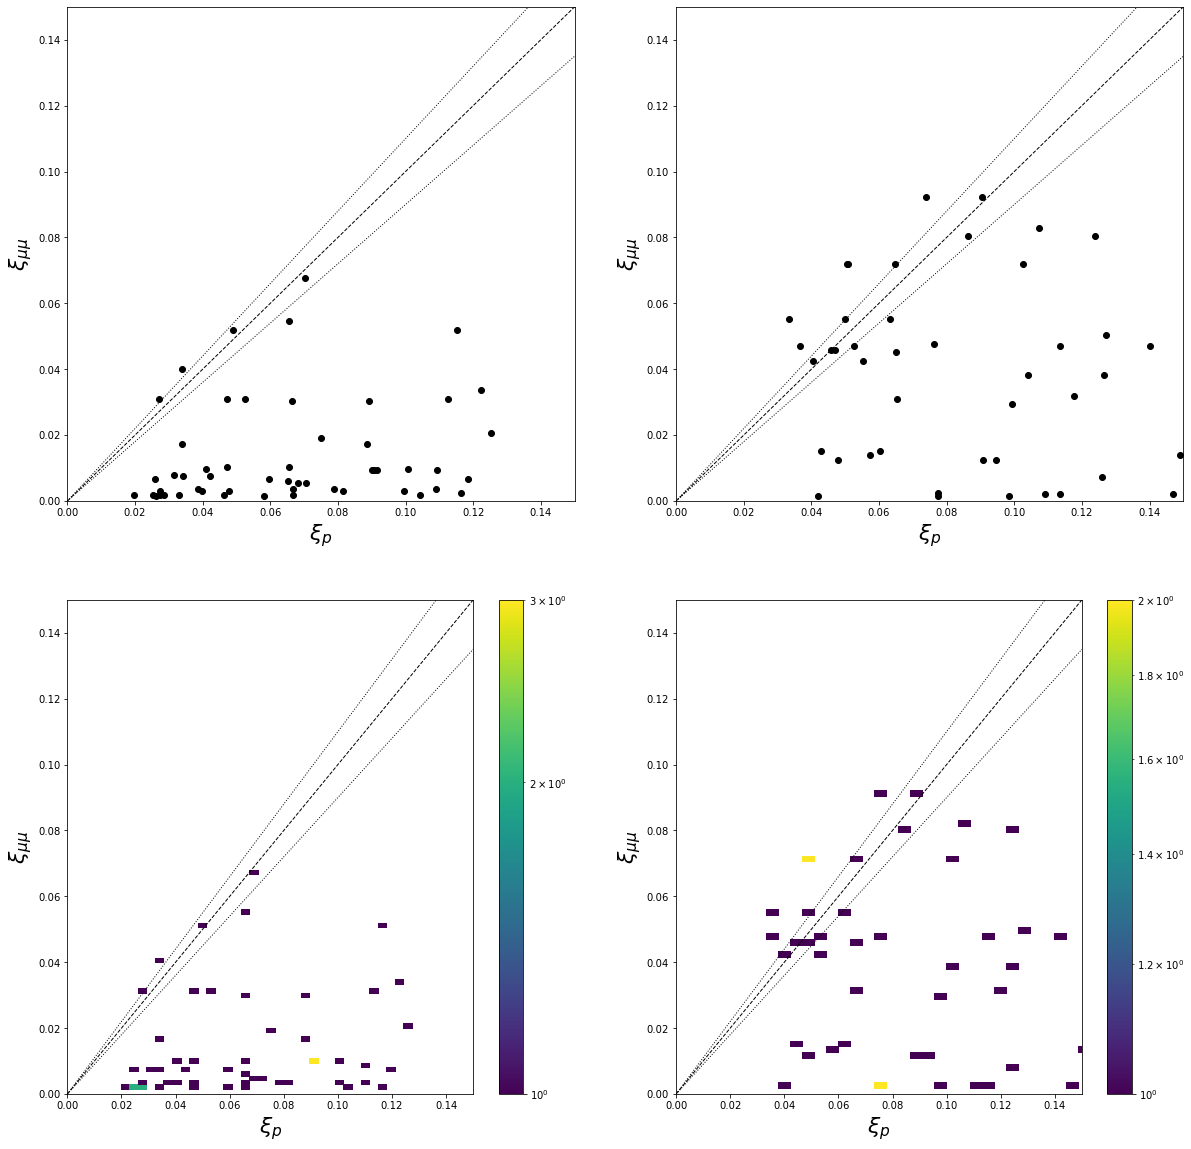

In [16]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_data[ "Xi" ][ msk_protons_1 ] ), len( df_data[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
axes[0,1].plot( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )